# Retrieve QASVM on IBMQ devices (montreal, toronto)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: choose config
DATA_TYPE = 'balanced' # 'unbalanced'
DEVICE = 'montreal' # 'toronto'
TEST_SIZE = 4
MAXITER = 5
LAST_AVG = 2**4
DIR_NAME = 'ibmq_run_device_2'

C=None
k=1

In [2]:
import dill
from pathlib import Path
import json
from classifiers.quantum import Qasvm_Mapping_4x2

model_dir = Path(f'./{DIR_NAME}/{DATA_TYPE}/{DEVICE}/')

with open(model_dir / 'exact_qasvm', 'rb') as f:
    exact_qasvm = dill.load(f)
with open(model_dir / 'exact_storage', 'rb') as f:
    exact_storage = dill.load(f)
exact_fvec = np.load(model_dir / 'exact_fvec.npy')

with open(model_dir / 'real_qasvm', 'rb') as f:
    real_qasvm = dill.load(f)
backend = real_qasvm.quantum_instance.backend
with open(model_dir / 'real_storage', 'rb') as f:
    real_storage = dill.load(f)
real_fvec = np.load(model_dir / 'real_fvec.npy')

with open(model_dir / 'sim_qasvm', 'rb') as f:
    sim_qasvm = dill.load(f)
with open(model_dir / 'sim_storage', 'rb') as f:
    sim_storage = dill.load(f)
sim_fvec = np.load(model_dir / 'sim_fvec.npy')

with open(model_dir / 'svm', 'rb') as f:
    svm = dill.load(f)
svm_fvec = np.load(model_dir / 'svm_fvec.npy')

with open(model_dir / 'uniform_qasvm', 'rb') as f:
    uniform_qasvm = dill.load(f)
uniform_fvec = np.load(model_dir / 'uniform_fvec.npy')
X = np.load(model_dir / 'X.npy')
y = np.load(model_dir / 'y.npy')
Xt = np.load(model_dir / 'Xt.npy')
yt = np.load(model_dir / 'yt.npy')
Xtt = np.load(model_dir / 'Xtt.npy')
ytt = np.load(model_dir / 'ytt.npy')

# Unknown bug fix
if len(exact_fvec) != len(yt):
    exact_fvec = exact_fvec[4:]
if len(sim_fvec) != len(yt):
    sim_fvec = sim_fvec[4:]
if len(real_fvec) != len(yt):
    real_fvec = real_fvec[4:]
if len(uniform_fvec) != len(yt):
    uniform_fvec = uniform_fvec[4:]
if len(svm_fvec) != len(ytt):
    svm_fvec = svm_fvec[4:]

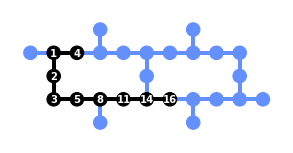

In [3]:
with open(model_dir / 'layout.json', 'r') as f:
    layout = Qasvm_Mapping_4x2(backend, **json.load(f))

layout.plot('physical')

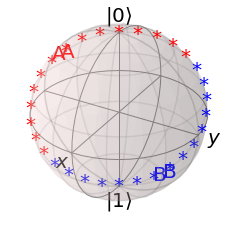

In [4]:
%matplotlib inline
ax = plt.axes(projection='3d')

from qiskit.visualization.bloch import Bloch
B = Bloch(axes=ax)

def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

vecs = np.array(list(map(s2c, X)))
for v in vecs[y==0]:
    B.add_annotation(v, text='A', color='r')
for v in vecs[y==1]:
    B.add_annotation(v, text='B', color='b')
# B.add_annotation(vecs.mean(axis=0), text='M', color='k')
vecA = vecs[y==0].mean(axis=0)
vecA = vecA/np.linalg.norm(vecA)
vecB = vecs[y==1].mean(axis=0)
vecB = vecB/np.linalg.norm(vecB)
vecP = (vecA-vecB)/np.linalg.norm(vecA-vecB)
vecQ = -(vecA-vecB)/np.linalg.norm(vecA-vecB)
#B.add_annotation(vecP, text='P', color='r')
#B.add_annotation(vecQ, text='Q', color='b')


vecs = np.array(list(map(s2c, Xt)))
for v in vecs[yt==0]:
    B.add_annotation(v, text='*', color='r')
for v in vecs[yt==1]:
    B.add_annotation(v, text='*', color='b')

B.render()
plt.savefig(f'/home/quic/Desktop/macbook/{DATA_TYPE}_bloch.png')

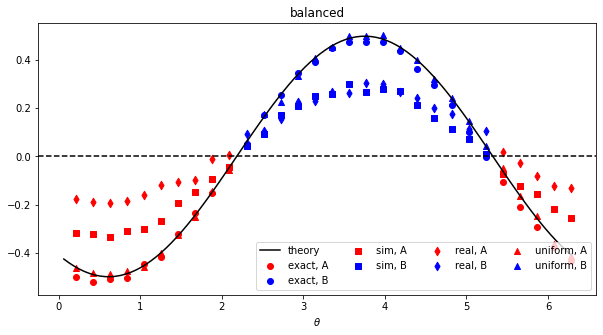

In [5]:
Stt = Xtt[:, 0]
St = Xt[:, 0]
offset = real_fvec.mean()
offset=0

plt.figure(figsize=(10, 5))
plt.plot(Stt[:], svm_fvec, color='k', label='theory')
plt.scatter(St[yt==0], exact_fvec[yt==0], c='r', marker='o', label='exact, A')
plt.scatter(St[yt==1], exact_fvec[yt==1], c='b', marker='o', label='exact, B')
plt.scatter(St[yt==0], sim_fvec[yt==0], c='r', marker='s', label='sim, A')
plt.scatter(St[yt==1], sim_fvec[yt==1], c='b', marker='s', label='sim, B')
plt.scatter(St[yt==0], real_fvec[yt==0] - offset, c='r', marker='d', label='real, A')
plt.scatter(St[yt==1], real_fvec[yt==1] - offset, c='b', marker='d', label='real, B')
plt.scatter(St[yt==0], uniform_fvec[yt==0], c='r', marker='^', label='uniform, A')
plt.scatter(St[yt==1], uniform_fvec[yt==1], c='b', marker='^', label='uniform, B')
plt.axhline(0, 0, 1, color='k', linestyle='--')
plt.legend(loc='best', ncol=4)
plt.xlabel(r'$\theta$')
plt.title(DATA_TYPE)
plt.savefig(f'/home/quic/Desktop/macbook/{DATA_TYPE}_result.png')

In [6]:
# old result
old_real_fvec = np.load(f'./summary_ipynb/2021/06 June/03 Thu/naive(montreal)/{DATA_TYPE}/regression.npy').mean(axis=0)
from classifiers.datasets.dataloader import Example_4x2
old_X, old_y = Example_4x2(DATA_TYPE=='balanced')()

sim_qasvm.parameters = np.array(real_storage.data.iloc[15][2:6])
new_sim_fvec = sim_qasvm.f(Xt)
sim_qasvm.parameters = np.array(real_storage.data.iloc[-1][2:6])
new_sim_fvec2 = sim_qasvm.f(Xt)
if len(new_sim_fvec)!=len(yt):
    new_sim_fvec = new_sim_fvec[4:]

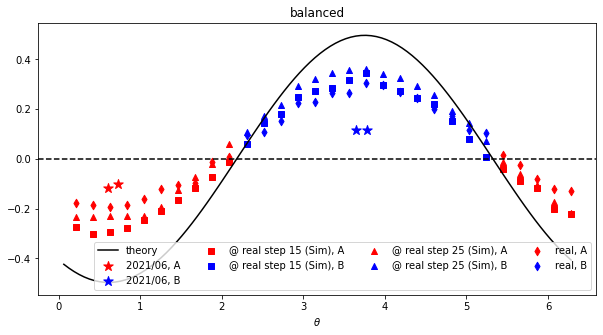

In [7]:
Stt = Xtt[:, 0]
St = Xt[:, 0]
old_S = np.where(old_X[:, 1]%(2*np.pi)>np.pi, ((-1)**(DATA_TYPE=='unbalanced')*old_X[:, 0])%(2*np.pi), ((-1)**(DATA_TYPE=='balanced')*old_X[:, 0])%(2*np.pi))
plt.figure(figsize=(10, 5))
plt.plot(Stt[:], svm_fvec, color='k', label='theory')
plt.scatter(old_S[old_y==0], old_real_fvec[old_y==0], c='r', marker='*', s=100, label='2021/06, A')
plt.scatter(old_S[old_y==1], old_real_fvec[old_y==1], c='b', marker='*', s=100, label='2021/06, B')
plt.scatter(St[yt==0], new_sim_fvec[yt==0], c='r', marker='s', label='@ real step 15 (Sim), A')
plt.scatter(St[yt==1], new_sim_fvec[yt==1], c='b', marker='s', label='@ real step 15 (Sim), B')
plt.scatter(St[yt==0], new_sim_fvec2[yt==0], c='r', marker='^', label=f'@ real step {len(real_storage.data)} (Sim), A')
plt.scatter(St[yt==1], new_sim_fvec2[yt==1], c='b', marker='^', label=f'@ real step {len(real_storage.data)} (Sim), B')
plt.scatter(St[yt==0], real_fvec[yt==0] - offset, c='r', marker='d', label='real, A')
plt.scatter(St[yt==1], real_fvec[yt==1] - offset, c='b', marker='d', label='real, B')
plt.axhline(0, 0, 1, color='k', linestyle='--')
plt.legend(loc='best', ncol=4)
plt.xlabel(r'$\theta$')
plt.title(DATA_TYPE)
plt.savefig(f'/home/quic/Desktop/macbook/{DATA_TYPE}_interp.png')

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/home/quic/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


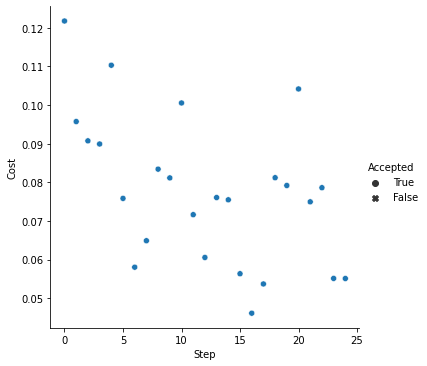

In [9]:
real_storage.plot()
plt.savefig(f'/home/quic/Desktop/macbook/{DATA_TYPE}_cost.png')

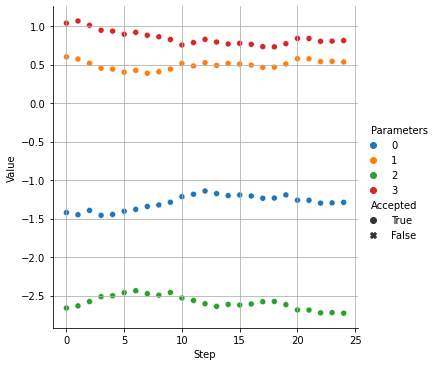

In [10]:
real_storage.plot_params()
plt.savefig(f'/home/quic/Desktop/macbook/{DATA_TYPE}_param.png')